# Makemore Back Propagation 

Implementing back prop from scratch instead of using loss.backward(). 

Manual back prop through cross entropy loss, 2nd linear layer, tanh, batchnorm, 1st linear layer, and the embedding table

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item() # check whether all elements in tensor exactly equal
  app = torch.allclose(dt, t.grad)    # check whether all elements in tensor approx equal 
  maxdiff = (dt - t.grad).abs().max().item() # check max difference 
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [14]:
n_embd = 10 
n_hidden = 64 

g = torch.Generator().manual_seed(2147483647)
C = torch.rand((vocab_size, n_embd),                generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * 5/3/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                          generator=g) * 0.1 # use for fun, useless bc of BN 
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.1 
b2 = torch.randn(vocab_size,                        generator=g) * 0.1 
bngain = torch.randn((1, n_hidden))* 0.1 + 1.0 
bnbias = torch.randn((1, n_hidden))* 0.1
# Note: initialising many of these params (bnbias) in non standard ways because initialising with all 0 will mask an incorrect backward pass

parameters = [C, W1, b1, W2, b2, bngain, bnbias]               
print(sum(p.nelement() for p in parameters))
for p in parameters: 
    p.requires_grad = True 

4137


In [15]:
n = 32 # batch size 

# construct minibatch 
ix = torch.randint(0, Xtr.shape[0], (n, ), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [ ]:
# forward pass, "chunkated" into smaller steps that are possible to backprop through 

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
# logits = xenc @ W 
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True)
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability since we are exponentiating later
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.5445, grad_fn=<NegBackward0>)

In [29]:
# Exercise 1: backprop through all variables manually using definitions in forward pass 

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0/probs) * dlogprobs # d(logx)dx = 1/x
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim = True) 
dcounts = counts_sum_inv * dprobs
dcounts_sum = -(counts_sum**-2)* dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts #d(norm_logits.exp()) = norm_logits.exp() = counts 
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T 
dW2 = h.T @ dlogits 
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh # d(tanh) = 1-tanh**2 
dbngain = (bnraw * dhpreact).sum(0, keepdim = True )
dbnraw = bngain * dhpreact 
dbnbias = dhpreact.sum(0, keepdim = True)
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim = True)
dbndiff = (bnvar_inv * dbnraw)
dbnvar = -0.5*(bnvar + 1e-5)**-1.5 * dbnvar_inv
dbndiff2 = (1.0/(n-1)*torch.ones_like(bndiff2) * dbnvar) 
dbndiff += 2*bndiff * dbndiff2
dbnmeani = (-dbndiff).sum(0, keepdim= True)
dhprebn = dbndiff.clone()
dhprebn += 1/n*torch.ones_like(hprebn) * dbnmeani 
dembcat = dhprebn @ W1.T 
dW1 = embcat.T @ dhprebn 
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]): 
    for j in range(Xb.shape[1]): 
        ix = Xb[k, j]
        dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar) 
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

Note: sum(1) - sum horizontally across columns, collapse columns into 1 col 
sum(0) - vertically across rows, collapse rows into 1 row 

dlogprobs: `loss = -logprobs[range(n), Yb].mean()` 
* logprobs (32, 27), Yb (32)
* forward pass: for row 0 in logprobs, pluck out Yb[0]th element (aka the logprob assigned to the correct element for example 0). go down the rows using iterator range(n)
* these elements get plucked out and their mean becomes loss 
* L = (-a-b-c)/n = aa/n -b/n -c/n --> dL/da = -1/n 
* For the other numbers that do not get plucked out -- dLdx = 0 
* dlogprobs should also be (32, 27), each row has 26 0s and 1 non zero in the position that hasbeen plucked out 

dprobs: `logprobs = probs.log()`
* dprobs (32, 27), dlogprobs (32, 27)
* d(logx)dx = 1/x 
* so we get `dprobs = (1.0/probs) * dlogprobs`
* intuitively: for correct chars that are assigned a low prob, 1/probs will be big, and will multiply by the dlogprobs. essentially it is boosting the gradient for wrong predictions

dcounts_sum_inv: `probs = counts * counts_sum_inv`
* counts (32, 27), counts_sum_inv (32, 1) 
* for counts_sum_inv, broadcasted in forward pass, col vector replicated for 27 cols, each element used 27 times. gradients should sum horizontally .sum(1, keepdim = True)
* backprob thru element wise multiplication: dcounts_sum_inv = counts * dprobs  
* backprob thru replication: dcounts_sum_inv = (counts * dprobs).sum(1, keepdim = True)

dcounts: `counts_sum = counts.sum(1, keepdims=True)`
* counts (32, 27), counts_sum (32, 1) 
* a11 a12 a13 --> b1 (=a11+a12+a13)
* a21 a22 a23 --> b2 (=a21+a22+a23)
* deriv of b1 wrt a11 a12 a13 are 1, and wrt the rest are 0 
* in chain rule, addition is like  arouter of gradients. whatever gradient comes from above gets routed to the the elements that participate in the addition
* dcounts = dcounts_sum.sum(1, keepdim= True)

dlogits: `norm_logits = logits - logit_maxes`
* a11 a12 a13 = b11 b12 b13 - c1 
* a21 a22 a23 = b21 b22 b23 - c2
* a22 = b22 - c2; db = 1, dc = -1 and since it is reused for all columns need to sum gradients horizontally
* note: the only reason why we calculate logit_maxes is so that norm-logits.exp() doesnt overflow later. values in logit_maxes should not affect probs or loss. hence grad wrt them should be 0 or extremely small values. and it is! 

dlogits: `logit_maxes = logits.max(1, keepdim=True).values`
* logits (32, 27) logit_maxes(32, 1).
* for each row in logits, the position that contains max has local deriv 1 and others have local deriv 0. then multiply with logit_maxes
* use one hot encoding to get 1 at positions of logits.max, num_classes=logits.shape[1]

dh, dW2, db2: `logits = h @ W2 + b2`
* dlogits (32, 27), dh (32, 64), dW2 (64, 27), b2 (27)  
* dX must be same dim as X, and dh is a matrix mul of dW2.T and dh (vice versa). theres only one way to multiply it so the dims work out 
* db2 is the sum of dlogits in some dim. since the dims must be 1,27 in the end, we are taking sum in 0th dimension. (note in broadcasting b2 became (1, 27) and got replicated for 32 rows, so sum across the rows) 

dbngain, dbnraw, dbnbias: `hpreact = bngain * bnraw + bnbias`
* hpreact (32, 64), bngain (1, 64), bnraw (32, 64), bnbias (1, 64)
* in broadcasting, bngain is being replicated into to 32 rows. each element is used 32 times. gradient must sum across rows. 
* same for bnbias 

dbndiff2: `bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)`
* bnvar (1, 64) bndiff2(32, 64)
* a11 a12 a13 --> b11 (= 1/(n-1)*(a11+a12+a13))
* dbndiff2 = 1/(n-1)*torch.ones_like(bndiff2) * dbnvar, 32,64 * 1,64 -- broadcasting where 1,64 is copied across 64 rows, after multiplication get 32,64

dhprebn: `bnmeani = 1/n*hprebn.sum(0, keepdim=True)`
* bnmeani (1,64), hprebn (32,64), sum horizontally 
* dhprebn = 1/n*torch.ones_like(hprebn) * dbnmeani 

demb: `embcat = emb.view(emb.shape[0], -1)`
* embcat (32, 30) emb (32, 3, 10)
* demb = dembcat.view(emb.shape)

emb = C[Xb]
* emb (32, 3, 10) C(27, 10) Xb(32, 3)
* in forward pass we used each value in Xb to index into the right row of C, and deposited into emb at the correct position 
* undo the indexing

### Exercise 2: Backprop through cross entropy in 1 go

Previously we implemented backprop individually through all the forward pass steps, but we can actually derive a simpler expression for loss and from there get the derivative, simplify the expression, and just write it out

In [ ]:
# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.544471025466919 diff: 2.384185791015625e-07


In [ ]:
# backward pass after math derivation 
dlogits = F.softmax(logits, 1)  # apply softmax of rows of logits
dlogits[range(n), Yb] -= 1      # subtract 1 from the correct element in each logit
dlogits /= n                    # back prop through mean

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


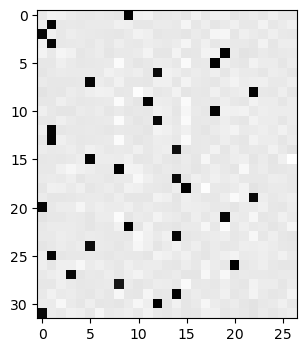

In [40]:
plt.figure(figsize=(4,4))
plt.imshow(dlogits.detach(), cmap='gray')
# black squares are the positions of the correct index where we subtracted 1 

These are the derivatives of dlogits 
* for each example (each row), dlogits is equal to probabilities (softmax of logits) for everything except for the correct char, where dlogits = probs-1 
* if take dlogits[0].sum(), get 0 
* think of dlogits (gradients) as a force that pulls down on probs of incorrect characters and pulls up on probs of correct characters. the amount of push and pull is exactly equalised because they sum to 0.  
* amount to which we push and pull is proportional to how far off our probabilities are. if probs were exactly correct (everything is 0 except correct position is 1), then dlogits row has everything as 0, meaning no push and pull force 

In [ ]:
# probabilities of each char for first example 
F.softmax(logits, 1)[0]

tensor([0.0234, 0.0678, 0.0658, 0.0415, 0.0273, 0.0244, 0.0335, 0.0240, 0.0150,
        0.0144, 0.0577, 0.0667, 0.0259, 0.0292, 0.0373, 0.0138, 0.0675, 0.0249,
        0.0619, 0.0655, 0.0120, 0.0308, 0.0405, 0.0244, 0.0573, 0.0225, 0.0250],
       grad_fn=<SelectBackward0>)

In [ ]:
# dlogits for first example (multiplied by n)
dlogits[0] * n

tensor([ 0.0234,  0.0678,  0.0658,  0.0415,  0.0273,  0.0244,  0.0335,  0.0240,
         0.0150, -0.9856,  0.0577,  0.0667,  0.0259,  0.0292,  0.0373,  0.0138,
         0.0675,  0.0249,  0.0619,  0.0655,  0.0120,  0.0308,  0.0405,  0.0244,
         0.0573,  0.0225,  0.0250], grad_fn=<MulBackward0>)

### Backprop through batchnorm in 1 go

Previously we implemented backprop individually through all the forward pass steps, but we can actually derive a simpler expression for the output of batchnorm `hpreact` and take the derivative wrt its input `hprebn`, simplify the expression, and just write it out

In [41]:
# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:  
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [42]:
# backward pass mathematically derived 
# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) 

hprebn          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [43]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

### Exercise 4: Putting it all together

In [52]:
# init
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer 

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 100000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # used only for correctness comparison

    # manual backprop 
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #if i >= 100: # to delete early breaking when you're ready to train the full net
        #break

12297
      0/ 200000: 3.8129
  10000/ 200000: 2.1830
  20000/ 200000: 2.3641
  30000/ 200000: 2.4971
  40000/ 200000: 1.9738
  50000/ 200000: 2.3662
  60000/ 200000: 2.3811
  70000/ 200000: 1.9873
  80000/ 200000: 2.4326
  90000/ 200000: 2.1775
 100000/ 200000: 1.9943
 110000/ 200000: 2.3453
 120000/ 200000: 2.0327
 130000/ 200000: 2.4296
 140000/ 200000: 2.3059
 150000/ 200000: 2.1114
 160000/ 200000: 1.9403
 170000/ 200000: 1.8315
 180000/ 200000: 1.9940
 190000/ 200000: 1.8742


In [ ]:
# to check: insert early break, uncomment out loss.backward(), comment out with torch.no_grad()
# for checking gradients:
for p,g in zip(parameters, grads):
    cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 8.381903171539307e-09
(200,)          | exact: False | approximate: True  | maxdiff: 6.51925802230835e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 4.190951585769653e-09


In [53]:
# calibrate BatchNorm for interference (get overall mean and var) 

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [54]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0706355571746826
val 2.1094236373901367


In [51]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahxqto.
hqvifi.
mrixreetl.
hklansaeja.
hnen.
qpnrrhc.
kaqhi.
oremari.
cemiiv.
kklegg.
hhlm.
eoi.
dqshnn.
shlin.
ariadbq.
wane.
ogdiarixi.
fkcekphrran.
ea.
ecoia.


In [55]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahzamille.
khi.
mri.
reety.
skanden.
jazonel.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
joce.
quinthorline.
liven.
corterri.
jarisi.
jaxen.
dustine.
deciia.
